<a href="https://colab.research.google.com/github/soy-min/climate-prognosis/blob/main/ClimatePrognosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import callbacks

Globale Parameter

In [168]:
START_YEAR_OBSERVATION='1963-01-01'
OBSERVATION_LOCATION_NAME='DEFAULT'
GLOBAL_PRINTOUTS=False

CSV laden

In [169]:
# Laden der CSV-Datei
#df = pd.read_csv('SW000002361.csv')
df = pd.read_csv('USC00122825.csv')
OBSERVATION_LOCATION_NAME=df.iloc[1]['NAME']
if GLOBAL_PRINTOUTS: print(df.head())
print(df.head())

       STATION     DATE  LATITUDE  LONGITUDE  ELEVATION  \
0  USC00122825  1893-01   40.2538   -85.1484      294.1   
1  USC00122825  1893-02   40.2538   -85.1484      294.1   
2  USC00122825  1893-04   40.2538   -85.1484      294.1   
3  USC00122825  1893-05   40.2538   -85.1484      294.1   
4  USC00122825  1893-06   40.2538   -85.1484      294.1   

                    NAME  CDSD  CDSD_ATTRIBUTES  CLDD CLDD_ATTRIBUTES  ...  \
0  FARMLAND 5 NNW, IN US   0.0              6.0   0.0              ,6  ...   
1  FARMLAND 5 NNW, IN US   0.0              6.0   0.0             2,6  ...   
2  FARMLAND 5 NNW, IN US   NaN              NaN   5.3              ,6  ...   
3  FARMLAND 5 NNW, IN US   NaN              NaN   9.7              ,6  ...   
4  FARMLAND 5 NNW, IN US   NaN              NaN   NaN             NaN  ...   

    SNOW SNOW_ATTRIBUTES   TAVG TAVG_ATTRIBUTES   TMAX TMAX_ATTRIBUTES   TMIN  \
0    NaN             NaN  -8.37              ,6  -3.54            ,,,6 -13.20   
1    NaN      

Reduzieren auf relevante Informationen

In [170]:
# Auswahl der relevanten Spalten (z.B. Datum, Temperatur)
df = df[['DATE', 'TMAX','TMIN']]
# Umbenennen der Spalten
df = df.rename(columns={'DATE': 'date', 'TMIN': 'temp_min','TMAX': 'temp_max'})
# Festlegen des Indexes als Datum
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
# reduzieren auf > START_YEAR_OBSERVATION
df=df.loc[START_YEAR_OBSERVATION:]
# NANs interpolieren
df=df.interpolate()
# einblick in die Daten
if GLOBAL_PRINTOUTS:df

#TODO:
#- Sicherstellen, dass Daten vollständig verfügbar sind (keine NANs am Anfang)

Visualisieren der Daten

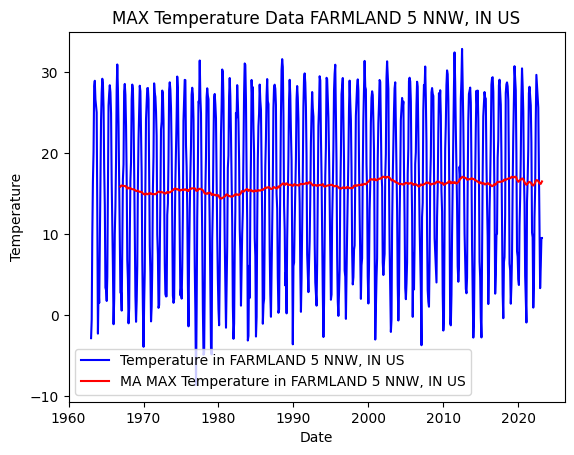

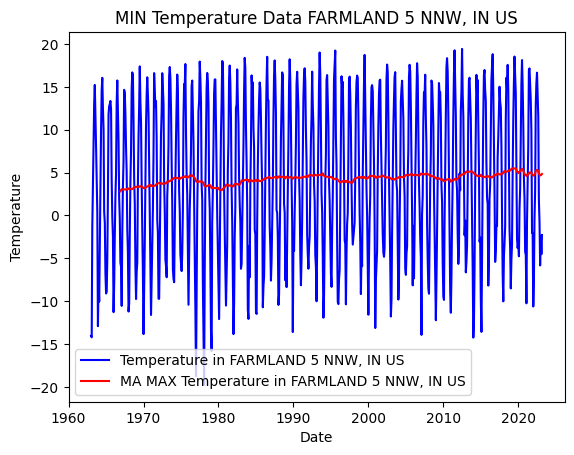

In [171]:
# Plotten der Ergebnisse
plt.figure(0)
plt.plot(df.index, df['temp_max'], color='blue', label='Temperature in '+OBSERVATION_LOCATION_NAME)
plt.plot(df.index, df.rolling(window=48).mean()['temp_max'], color='red', label='MA MAX Temperature in '+OBSERVATION_LOCATION_NAME)
plt.title('MAX Temperature Data '+OBSERVATION_LOCATION_NAME)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.figure(1)
plt.plot(df.index, df['temp_min'], color='blue', label='Temperature in '+OBSERVATION_LOCATION_NAME)
plt.plot(df.index, df.rolling(window=48).mean()['temp_min'], color='red', label='MA MAX Temperature in '+OBSERVATION_LOCATION_NAME)
plt.title('MIN Temperature Data '+OBSERVATION_LOCATION_NAME)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

Trainings und Testdaten separieren

In [172]:
# Teilen der Daten in Trainings- und Testdaten
train_min, test_min = train_test_split(df[["temp_min"]], test_size=0.3, shuffle=False)
train_max, test_max = train_test_split(df[["temp_max"]], test_size=0.3, shuffle=False)
# Ergebnis einsehen
if GLOBAL_PRINTOUTS:test_min

Normierung auf Werte 0..1

In [173]:
# Skalieren der Daten
scaler = MinMaxScaler()
train_scaled_min = scaler.fit_transform(train_min)
test_scaled_min = scaler.transform(test_min)
all_scaled_min=scaler.fit_transform(df[["temp_min"]])
train_scaled_max = scaler.fit_transform(train_max)
test_scaled_max = scaler.transform(test_max)
all_scaled_max=scaler.fit_transform(df[["temp_max"]])
# Ergebnis einsehen
if GLOBAL_PRINTOUTS:test_scaled_max

In [179]:


# Vorbereiten der Trainingsdaten
look_back = 120 # Anzahl der vorherigen Monate, die zur Vorhersage verwendet werden
def fitModel(training_data, all_data):
  X_train = []
  y_train = []
  X_validate=[]
  y_validate=[]
  for i in range(look_back, len(training_data)):
      X_train.append(training_data[i-look_back:i, 0])
      y_train.append(training_data[i, 0])
  X_train, y_train = np.array(X_train), np.array(y_train)

  for i in range(len(training_data),len(all_data)):
      X_validate.append(all_data[i-look_back:i, 0])
      y_validate.append(all_data[i, 0])
  X_validate, y_validate = np.array(X_validate), np.array(y_validate)

  # Umformen der Daten in das erforderliche 3D-Array-Format
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  X_validate = np.reshape(X_validate, (X_validate.shape[0], X_validate.shape[1], 1))

  #earlystopping mechanismus
  earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)


  # Definieren und Trainieren des LSTM-Modells
  model = Sequential()
  model.add(LSTM(units=look_back, return_sequences=True, input_shape=(X_train.shape[1], 1)))
  model.add(LSTM(units=look_back))
  model.add(Dense(units=1))
  model.compile(optimizer='adam', loss='mean_squared_error')
  history=model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_validate, y_validate),callbacks=[earlystopping])


  return model,history

model_min,model_min_history=fitModel(train_scaled_min,all_scaled_min)
model_max,model_max_history=fitModel(train_scaled_max,all_scaled_max)




Epoch 1/50
13/13 [==============================] - 19s 1s/step - loss: 0.1377 - val_loss: 0.0841
Epoch 2/50
13/13 [==============================] - 13s 1s/step - loss: 0.0673 - val_loss: 0.0656
Epoch 3/50
13/13 [==============================] - 11s 845ms/step - loss: 0.0660 - val_loss: 0.0579
Epoch 4/50
13/13 [==============================] - 14s 1s/step - loss: 0.0633 - val_loss: 0.0596
Epoch 5/50
13/13 [==============================] - 10s 762ms/step - loss: 0.0582 - val_loss: 0.0540
Epoch 6/50
13/13 [==============================] - 13s 1s/step - loss: 0.0615 - val_loss: 0.0553
Epoch 7/50
13/13 [==============================] - 14s 1s/step - loss: 0.0560 - val_loss: 0.0480
Epoch 8/50
13/13 [==============================] - 11s 878ms/step - loss: 0.0483 - val_loss: 0.0369
Epoch 9/50
13/13 [==============================] - 11s 865ms/step - loss: 0.0297 - val_loss: 0.0088
Epoch 10/50
13/13 [==============================] - 10s 828ms/step - loss: 0.0085 - val_loss: 0.0077
Epoc

Plot Fitting History

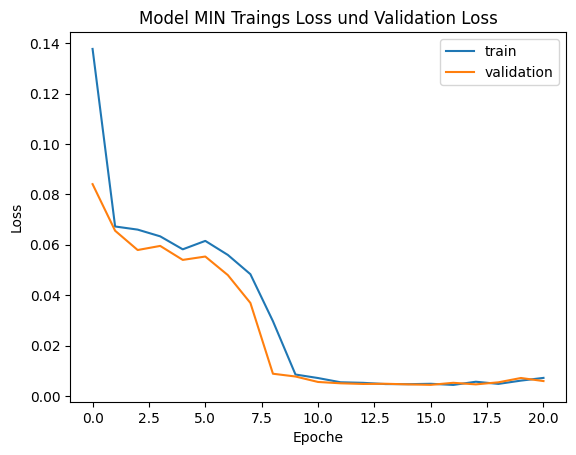

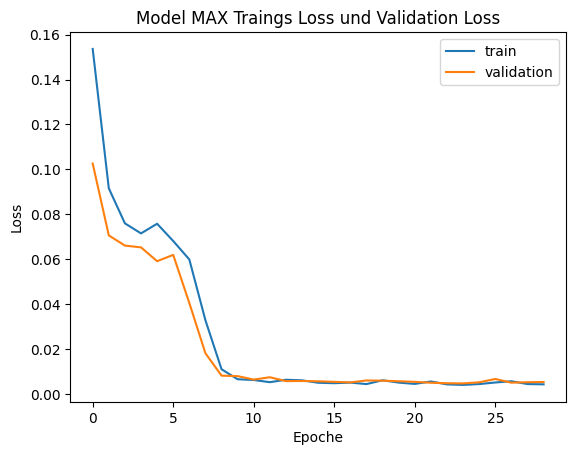

In [180]:
def plotHistory(model,prefix,plot_id):
  # plot train and validation loss
  plt.figure(plot_id)
  plt.plot(model.history['loss'])
  plt.plot(model.history['val_loss'])
  plt.title('Model '+prefix+' Traings Loss und Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoche')
  plt.legend(['train', 'validation'], loc='upper right')

plotHistory(model_min_history, "MIN", 0)
plotHistory(model_max_history, "MAX", 1)

plt.show()

Modell Validieren

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


7/7 [==============================] - 2s 169ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


7/7 [==============================] - 3s 259ms/step


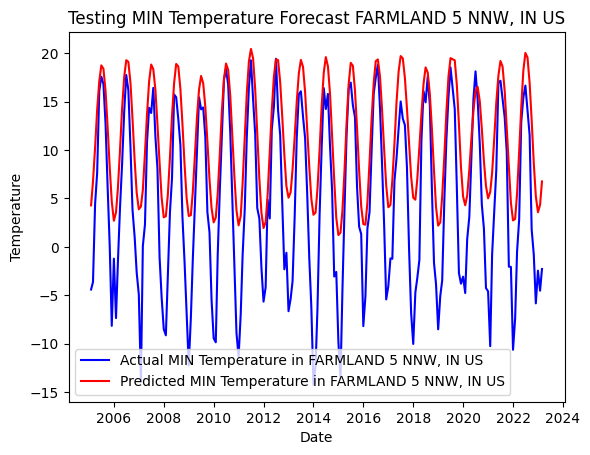

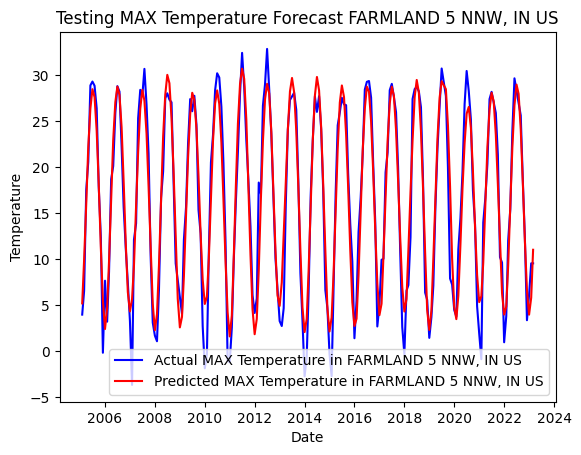

In [181]:
# Vorbereiten der Testdaten

def prepareAndPlot(model,df,testdata, prefix, plot_id):
  inputs = df[len(df) - len(testdata) - look_back:].values
  inputs = scaler.transform(inputs)
  X_test = []
  for i in range(look_back, len(inputs)):
      X_test.append(inputs[i-look_back:i, 0])
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  # Vorhersage der Temperaturen
  predicted = model.predict(X_test)
  predicted = scaler.inverse_transform(predicted)

  # Plotten der Ergebnisse
  plt.figure(plot_id)
  plt.plot(testdata.index, testdata.iloc[:,0], color='blue', label='Actual '+prefix+' Temperature in '+OBSERVATION_LOCATION_NAME)
  plt.plot(testdata.index, predicted, color='red', label='Predicted '+prefix+' Temperature in '+OBSERVATION_LOCATION_NAME)
  plt.title('Testing '+prefix+' Temperature Forecast '+OBSERVATION_LOCATION_NAME)
  plt.xlabel('Date')
  plt.ylabel('Temperature')
  plt.legend()

prepareAndPlot(model_min,df[["temp_min"]],test_min,"MIN",0)
prepareAndPlot(model_max,df[["temp_max"]],test_max,"MAX",1)


plt.show()

Prognose auf Zukunft anwenden

In [182]:
def calculateResults(df,model):
  df_future=df[-look_back:]
  prediction_period=60 #months
  results = np.zeros(shape=(prediction_period, 1))
  last_known_dateindex=df_future.iloc[[-1]].index

  for i in range(0,prediction_period):
    F_test = []
    inputs=scaler.transform(df_future[-look_back:].values)
    F_test.append(inputs)
    F_test= np.array(F_test)
    F_test = np.reshape(F_test, (F_test.shape[0], F_test.shape[1], 1))
    # Vorhersage der Temperaturen n=1
    predicted = model.predict(F_test)
    predicted = scaler.inverse_transform(predicted)
    predicted
    results[i]=predicted

    # add predicted element to df_future
    next_date = last_known_dateindex + pd.DateOffset(months=i+1)
    df_future=pd.concat([df_future,pd.DataFrame({ df_future.columns[0]:predicted[0]}, index=next_date)])

  if GLOBAL_PRINTOUTS: results
  return df_future

df_future_min=calculateResults(df[["temp_min"]], model_min)
df_future_max=calculateResults(df[["temp_max"]], model_max)

1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 70ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 74ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 63ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 70ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 40ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 40ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 43ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 44ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 40ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 46ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 42ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 45ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 43ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 36ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 36ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 41ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 74ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 67ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 44ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 41ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 360ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 46ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 43ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 43ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 40ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 41ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 42ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 42ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 38ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 41ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 38ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 43ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 39ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 73ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 65ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 42ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 41ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


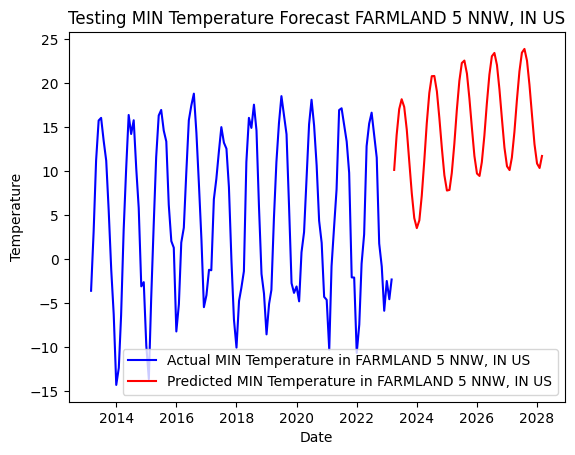

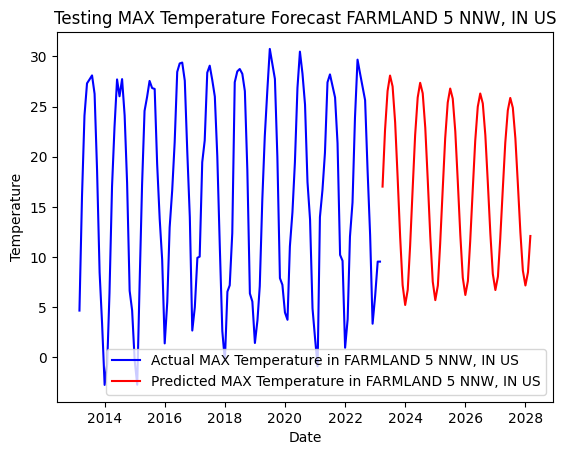

In [183]:


# Plotten der Ergebnisse
def plotResults(df_future, prefix, plot_id):
  plt.figure(plot_id)
  plt.plot(df_future[:look_back].index, df_future[:look_back], color='blue', label='Actual '+prefix+' Temperature in '+OBSERVATION_LOCATION_NAME)
  plt.plot(df_future[look_back:].index, df_future[look_back:], color='red', label='Predicted '+prefix+' Temperature in '+OBSERVATION_LOCATION_NAME)
  plt.title('Testing '+prefix+' Temperature Forecast '+OBSERVATION_LOCATION_NAME)
  plt.xlabel('Date')
  plt.ylabel('Temperature')
  plt.legend()

plotResults(df_future_min,"MIN",0)
plotResults(df_future_max,"MAX",1)


plt.show()